In [1]:
%matplotlib inline

from sklearn import svm
from WAVreader import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pyaudio
import numpy as np
from scipy.fftpack import fft, dct
from pylab import *
from numpy import dot
import os

In [2]:
filelist = ['davis.wav',
            'davis2.wav'
            ]
info = WAVreader(filelist, [1,0], 0.05)
data = info.svmset

7.6605
Scaled 1331 windows down to 1175
Finished file davis.wav
12.8055
Scaled 1331 windows down to 1295
Finished file davis2.wav

Final data set consists of 2462 windows over 2 classes


In [3]:
weights = map(lambda x: sum([1 if clip[1]==x else 0 for clip in data]), range(info.numClasses))
weightdict = dict(zip(range(info.numClasses),[(sum(weights)+.0)/weight for weight in weights]))
print weightdict

clf = svm.SVC()#class_weight=weightdict)
#Fetch the unlabeled data points
X = np.array([clip[0] for clip in data])
#Normalize the data
meanX = np.mean(X, axis=0)
varX = np.var(X, axis=0)
standardX = np.divide(X-meanX, varX)
Y = np.array([clip[1] for clip in data])
clf.fit(standardX,Y) 
print clf.score(standardX, Y)

{0: 1.9070487993803253, 1: 2.1024765157984628}
0.989439480097


Confusion matrix
[[1280   11]
 [  15 1156]]


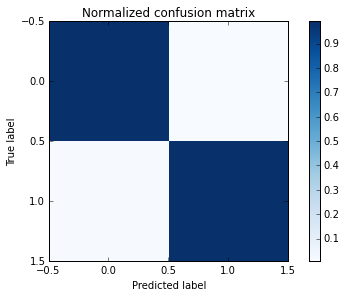

In [4]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ytrue = Y
ypred = []
for clip in standardX:
    ypred.append(clf.predict(clip))
confusion=confusion_matrix(ytrue, ypred)
cm_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
print('Confusion matrix')
print(confusion)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [26]:
# precisions = np.array([(confusion[i][i]+0.0)/np.sum(confusion, axis=0)[i] for i in range(info.numClasses)])
# meanp = np.mean(precisions)
# recalls = np.array([(confusion[i][i]+0.0)/sum(confusion[i]) for i in range(info.numClasses)])
# meanr = np.mean(recalls)
# F1 = 2*meanr*meanp/(meanr+meanp)
# print meanp
# print meanr
# print F1

In [6]:
# LOOP VARIABLES
tracker = [3 for _ in range(15)]
key = {0:'Davis', 1:'Aashna', 2:'James', 3:'Nobody'}
currdisp = 3

#AUDIO VARIABLES
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
samplelen = 1323.0
audio = pyaudio.PyAudio()
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)

#MFCC VARIABLES
#Get frequency range
T = samplelen/RATE
frqLabel = map(lambda i: i/T, range(int(samplelen/2-1)))
#Transform frequencies to Mel Frequencies
melLabel = map(lambda i: 1125*log(1+i/700), frqLabel)
melPoints = [(melLabel[-1]-1.0)/27*i for i in range(28)]
melFilters = [[max(0, min(1.0/(melPoints[i+1]-melPoints[i])*(x-melPoints[i+1]+.0)+1.0,
                        -1.0/(melPoints[i+2]-melPoints[i+1])*(x-melPoints[i+1]+.0)+1.0))
             for x in melLabel] for i in range(26)]

# THE LOOP
print "Nobody is speaking!"
while(True):

    #RECORD SAMPLES
    clip = []
    for i in range(4): #int(RATE/CHUNK*0.33)):
        frames = stream.read(CHUNK)
        clip = np.append(clip,np.fromstring(frames, dtype=np.int16)/100.0)
#     clip = clip[len(clip)*3/11:len(clip)*8/11]    
    
    if max(np.abs(clip)) < 10:
        tracker.pop(0)
        tracker.append(3)
    else:
        samples = [clip[i*samplelen/2:i*samplelen/2+samplelen] for i in range(int(len(clip)/samplelen*2))]
        #Fourier Transform
        ffts = [c[:samplelen/2-1] for c in map(lambda i: abs(fft(i)), samples[:-1])]

        #Apply filters and cosine transform
        MFCCs = map(dct, [[np.dot(f, melFilters[i]) for i in range(26)] for f in ffts])

        #Calculate delta
        delta = [(MFCCs[3][j]+2*MFCCs[4][j]-MFCCs[1][j]-2*MFCCs[0][j])/10.0
                  for j in range(26)]

        #Perform log-scaling
        lnMFCC = [np.sign(MFCCs[2][i])*log(abs(MFCCs[2][i])/1000.0) for i in range(26)]
        lnDelta = [np.sign(delta[i])*log(abs(delta[i])/10.0) for i in range(26)]
        
        point = np.concatenate((lnMFCC,lnDelta))
        tracker.pop(0)
        tracker.append(clf.predict(np.divide(point-meanX, varX))[0])

    os.system('cls')
    freq = max(set(tracker), key=tracker.count)
    if freq != currdisp:
        currdisp = freq
        print key[freq]+" is speaking!"
        print tracker
        

        
#         plt.figure(1)
#         plt.plot(np.divide(point[2:]-meanX, varX))
#         plt.plot(np.divide(data[5000][0][2:]-meanX, varX))
#         plt.figure(2)
#         plt.plot(clip)


Nobody is speaking!
Davis is speaking!
[3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0]
Nobody is speaking!
[0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3]
Aashna is speaking!
[3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
Nobody is speaking!
[1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3]
Aashna is speaking!
[3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
Nobody is speaking!
[1, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3]
Davis is speaking!
[3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0]
Nobody is speaking!
[0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3]
Aashna is speaking!
[3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
Nobody is speaking!
[1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3]
Davis is speaking!
[3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0]
Nobody is speaking!
[0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3]


KeyboardInterrupt: 

In [32]:
print map(lambda i: (clf.predict(np.divide(data[i][0]-meanX, varX))[0], data[i][1]), range(50))

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
